In [1]:
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
import pickle

from SSD300.ssd_v2 import SSD300v2
from SSD300.ssd_training import MultiboxLoss
from SSD300.ssd_utils import BBoxUtility

from get_data_from_XML import XML_preprocessor
from generator import Generator

voc_classes = ['Aeroplane', 'Bicycle', 'Bird', 'Boat', 'Bottle',
               'Bus', 'Car', 'Cat', 'Chair', 'Cow', 'Diningtable',
               'Dog', 'Horse','Motorbike', 'Person', 'Pottedplant',
               'Sheep', 'Sofa', 'Train', 'Tvmonitor']
NUM_CLASSES = len(voc_classes) + 1
input_shape = (300, 300, 3)

model = SSD300v2(input_shape, num_classes=NUM_CLASSES)

loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss
model.compile(optimizer='Adadelta', loss=loss)

# model.summary()

Using TensorFlow backend.


In [2]:
#priors = pickle.load(open('./SSD300/prior_boxes_ssd300.pkl', 'rb'))
priors = pickle.load(open('./SSD300/default_box_information.pkl', 'rb'))
bbox_util = BBoxUtility(NUM_CLASSES, priors)

In [ ]:
pascal_voc_07_parser = XML_preprocessor(data_path='./VOCdevkit/VOC2007/Annotations/')
#len(pascal_voc_07_parser.data) = 5011

#print(pascal_voc_07_parser.data['000007.jpg'])
# array([[ 0.282     ,  0.15015015,  1.        ,  0.99099099,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
#          0.        ,  0.        ,  0.        ,  0.        ]])

keys = list(pascal_voc_07_parser.data.keys())
train_num = int(0.7 * len(keys))
train_keys = keys[:train_num]
val_keys = keys[train_num:]
gen = Generator(gt=pascal_voc_07_parser.data, bbox_util=bbox_util,
                 batch_size=16, path_prefix='./VOCdevkit/VOC2007/JPEGImages/',
                 train_keys=train_keys, val_keys=val_keys, image_size=(300, 300))


In [ ]:
RUN = RUN + 1 if 'RUN' in locals() else 1

LOG_DIR = '/output/training_logs/run{}'.format(RUN)
LOG_FILE_PATH = LOG_DIR + '/checkpoint-{epoch:02d}-{val_loss:.4f}.hdf5'

EPOCHS = 32

tensorboard = TensorBoard(log_dir=LOG_DIR, write_images=True)
checkpoint = ModelCheckpoint(filepath=LOG_FILE_PATH, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

history = model.fit_generator(generator=gen.generate(True), steps_per_epoch=int(gen.train_batches / 4),
                              validation_data=gen.generate(False), validation_steps=int(gen.val_batches / 4),
                              epochs=EPOCHS, verbose=1, callbacks=[tensorboard, checkpoint, early_stopping])

E:\Soft2\Anaconda\envs\py3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/32
  7/876 [..............................] - ETA: 22:38:34 - loss: 3492016141383419392.0000

In [6]:
model.load_weights('./PASCAL_VOC_SSD300_weight_checkpoint-epoch-16-loss-3.3392.hdf5', by_name=True)

In [ ]:
freeze = ['input_1', 'conv1_1', 'conv1_2', 'pool1',
          'conv2_1', 'conv2_2', 'pool2',
          'conv3_1', 'conv3_2', 'conv3_3', 'pool3']
for L in model.layers:
    if L.name in freeze:
        L.trainable = False


def schedule(epoch, decay=0.9):
    return base_lr * decay**(epoch)
 
callbacks = [keras.callbacks.ModelCheckpoint('./checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5',
                                             verbose=1,
                                             save_weights_only=True),
             keras.callbacks.LearningRateScheduler(schedule)]
base_lr = 3e-4
optim = keras.optimizers.Adam(lr=base_lr)
# optim = keras.optimizers.RMSprop(lr=base_lr)
# optim = keras.optimizers.SGD(lr=base_lr, momentum=0.9, decay=decay, nesterov=True)
model.compile(optimizer=optim,
              loss=MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss)
nb_epoch = 30
history = model.fit_generator(gen.generate(True), gen.train_batches,
                              nb_epoch, verbose=1,
                              callbacks=callbacks,
                              validation_data=gen.generate(False),
                              nb_val_samples=gen.val_batches,
                              nb_worker=1)


In [5]:
from keras.preprocessing import image
from scipy.misc import imread
from keras.applications.imagenet_utils import preprocess_input
import numpy as np
import matplotlib.pyplot as plt

files = ('fish-bike.jpg', 'cat.jpg', 'boys.jpg', 'car_cat.jpg', 'car_cat2.jpg')

inputs = []
images = []
for f in files:
    f = "./pics/{}".format(f)
    img = image.load_img(""+f, target_size=(300, 300))
    img = image.img_to_array(img)
    images.append(imread(f))
    inputs.append(img.copy())
    

inputs = preprocess_input(np.array(inputs))

preds = model.predict(inputs, batch_size=1, verbose=1)
# preds.shape (5, 7308, 33)
#print(preds[0,0,:])

results = bbox_util.detection_out(preds)
# type(results): list, len(results): 5, len(result[0]): 200, results[0].shape: (200, 6)

E:\Soft2\Anaconda\envs\py3\lib\site-packages\ipykernel_launcher.py:15: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


5/5 [==============================] - 5s 975ms/step


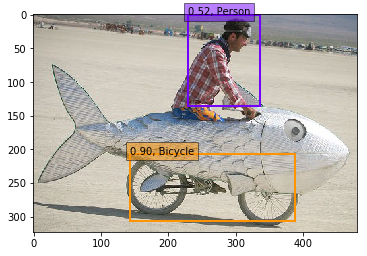

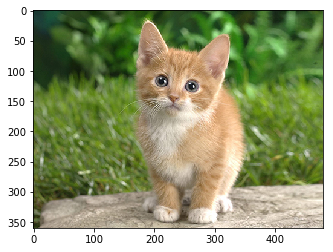

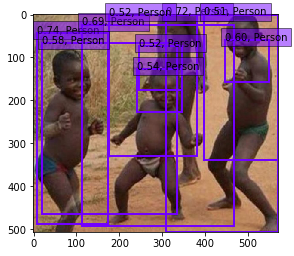

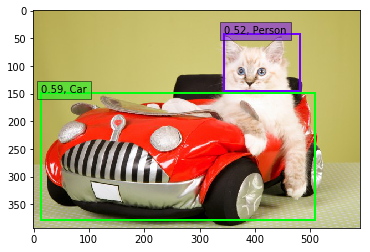

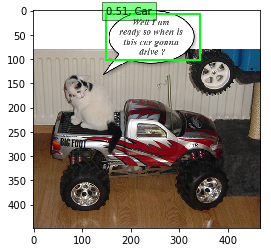

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

for i, img in enumerate(images):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.5]

    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()

    plt.imshow(img / 255.)
    currentAxis = plt.gca()

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
        label_name = voc_classes[label - 1]
        display_txt = '{:0.2f}, {}'.format(score, label_name)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()